In [7]:
import pandas as pd
from urllib.parse import urlparse
import re
import ipaddress

# Load the dataset
df = pd.read_csv('urldata.csv')

# Inspect data
df.sample(100)

,Unnamed: 0,url,label,result
206733,206733,https://www.greatcanadatravel.com/,benign,0
356130,356130,http://abs-kasyfiskalne.pl/tmp/,malicious,1
227184,227184,https://www.kilidavid.com/Art/Pages/Artists/de...,benign,0
292351,292351,https://www.songlyrics.com/beyonce-knowles/sin...,benign,0
359673,359673,http://lastik.com/download/lion/yh/yh/y/cameo.php,malicious,1
...,...,...,...,...
17776,17776,https://www.classicmoviefavorites.com/shearer/...,benign,0
118317,118317,https://www.wild.nhl.com/club/preview.htm?id=2...,benign,0
97174,97174,https://www.sfist.com/2007/04/29/macarthur_maz...,benign,0
55950,55950,https://www.hockey--jcesar77.blogspot.com/,benign,0


In [8]:
# feature extraction preformed by URLFeatureExtraction.py
# python URLFeatureExtraction.py urldata.csv returns featuredata.csv
df = pd.read_csv('featuredata.csv', on_bad_lines='skip')

features = ['Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection', 
                        'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record',
                        'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards']


In [9]:
# Convert the features into separate columns
# df_features = pd.DataFrame(df['features'].tolist(), index=df.index, columns=features)

# Combine the extracted features with the original DataFrame
# df_combined = pd.concat([df, df_features], axis=1)
df = df.dropna(subset=['Label'])


In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Define X (features) and y (target)
X = df[features]
y = df['Label']

# Step 1: Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Use SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Train the model on the resampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Step 4: Make predictions on the test set
y_pred = rf_model.predict(X_test)



In [11]:
# Feature extracted URLs tested
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=5, batch_size=128, validation_data=(X_test, y_test))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')



Epoch 1/5


c:\Users\Matthew\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6407 - loss: 0.6277 - val_accuracy: 0.7349 - val_loss: 0.5207
Epoch 2/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7297 - loss: 0.5400 - val_accuracy: 0.7393 - val_loss: 0.5081
Epoch 3/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7362 - loss: 0.5287 - val_accuracy: 0.7426 - val_loss: 0.5045
Epoch 4/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7429 - loss: 0.5182 - val_accuracy: 0.7430 - val_loss: 0.5021
Epoch 5/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7445 - loss: 0.5129 - val_accuracy: 0.7498 - val_loss: 0.5020
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.7528 - loss: 0.5017
Test Accuracy: 0.7498027682304382


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam

# Step 1: Prepare the data (0 for benign, 1 for phishing)

# Tokenize the URLs (character-level tokenization)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['URL'])

# Convert the URLs into sequences of integers
url_sequences = tokenizer.texts_to_sequences(df['URL'])

# Pad the sequences to make them of equal length
max_sequence_length = 100  # can be adjusted based on data
X = pad_sequences(url_sequences, maxlen=max_sequence_length)

# Target labels
y = df['Label'].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Total number of unique characters
embedding_dim = 50  # Size of the character embedding vectors

model = Sequential()
# Embedding layer (convert each character to a dense vector)
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
# LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False)))
# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy Bi: {accuracy}')

Epoch 1/5


c:\Users\Matthew\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


278/278 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.8118 - loss: 0.3761 - val_accuracy: 0.9749 - val_loss: 0.0940
Epoch 2/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.9693 - loss: 0.1103 - val_accuracy: 0.9707 - val_loss: 0.1004
Epoch 3/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.9426 - loss: 0.1539 - val_accuracy: 0.9759 - val_loss: 0.0856
Epoch 4/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - accuracy: 0.9772 - loss: 0.0743 - val_accuracy: 0.9792 - val_loss: 0.0699
Epoch 5/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.9870 - loss: 0.0417 - val_accuracy: 0.9932 - val_loss: 0.0226
278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9926 - loss: 0.0235
Test Accuracy Bi: 0.9932379126548767


278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


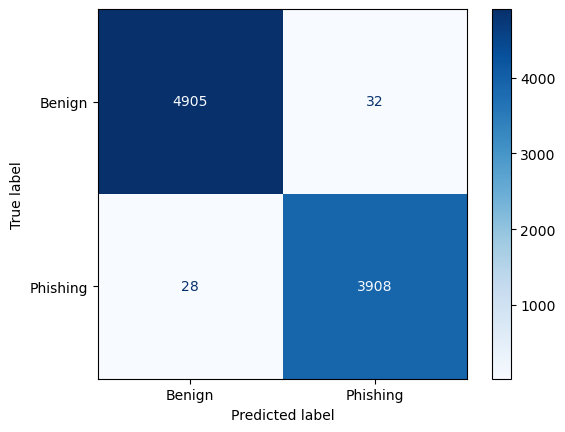

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# step 1: make predictions on test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# step 2: gererate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# step 3: display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Phishing"])
disp.plot(cmap="Blues", values_format='d')